# Ornella Elena Grassi, Giulio Nenna
## Politecnico di Torino, A.Y. 2022/2023

## Introduction

The aim of this homework is to apply the Principal Component Analysis to a dataset which collects instances from the Online Motorcycle Catalog (bikez.com) updated to April 30, 2022.
The data .....
######## TODO say something about the dataset


## Preparation (Setting the Random State)
To start our analysis let's import the useful packages and set our plot parameters.
Additionally, we'll set the *random seed* as *rs = min{290310, ???}*, the minimum between our student IDs. It'll be used as the seed for random computations throughout the full analysis.

In [22]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 200

#some parameters set to make graphs nicer
plt.style.use('default')
# plt.rcParams['axes.facecolor'] = 'none'
#plt.rcParams['axes.grid'] = True
# plt.rcParams['figure.frameon'] = True

plt.rcParams['grid.color'] = '#000000'

#setting random seed
rs = 290310
np.random.seed(rs)

## Exercise 1 (Loading and Preparing the Data)
### Section (a), (b)
The dataframe is loaded and saved as a pandas DataFrame. Then, an amount of $\approx 1/3 $ of the DF is selected and saved in the sub-DF *workdf*.

In [23]:
df_path = 'data\cla4lsp22_bikez_curated.csv'
df_tot = pd.read_csv(df_path)
print(f'Original DataFrame dimensions: {df_tot.shape}')

r = np.random.randint(0,3)
workdf = df_tot.loc[df_tot['Year']%3 == r]

Original DataFrame dimensions: (38472, 27)


### Section (c)
The following code snippet divides our columns into *labels* and *features* and then chooses two random features to remove among the following: *Front/Rear brakes, Front/Rear tire, Front/suspension*. Lastly, it shows the resulting dataframe.

In [24]:
labels = workdf.iloc[:, :5].columns.tolist()
features = workdf.iloc[:, 5:].columns.tolist()

features_to_remove = ['Front brakes', 'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension', 'Rear suspension']

features_to_remove = np.random.choice(features_to_remove, size=2, replace = False)

workdf.drop(columns=features_to_remove, axis = 1, inplace=True)
features = [x for x in features if x not in features_to_remove]

print(f'Columns {features_to_remove} have been dropped from the DF')
print(f'Updated dimensions: {workdf.shape}')
display(workdf)

Columns ['Rear tire' 'Front suspension'] have been dropped from the DF
Updated dimensions: (13673, 25)


,Brand,Model,Year,Category,Rating,Displacement (ccm),Power (hp),Torque (Nm),Engine cylinder,Engine stroke,Gearbox,Bore (mm),Stroke (mm),Fuel capacity (lts),Fuel control,Cooling system,Transmission type,Dry weight (kg),Wheelbase (mm),Seat height (mm),Fuel system,Front brakes,Rear brakes,Front tire,Rear suspension
1,acabion,gtbo 55,2007,Sport,2.6,1300.0,541.0,420.0,In-line four,four-stroke,6-speed,81.0,63.0,NaN,Not Given/Unknown,Liquid,Not Given/Unknown,360.0,NaN,NaN,other,not given/unknown,not given/unknown,other,not given/unknown
4,acabion,gtbo 70,2007,Prototype / concept model,3.1,1300.0,689.0,490.0,In-line four,four-stroke,6-speed,81.0,63.0,NaN,Not Given/Unknown,Liquid,Not Given/Unknown,300.0,NaN,NaN,other,not given/unknown,not given/unknown,other,not given/unknown
6,access,ams 3.20 supercross,2016,ATV,NaN,280.0,18.8,NaN,Single cylinder,four-stroke,Automatic,NaN,NaN,14.0,Overhead Valves (OHV),Air,Chain,225.0,NaN,NaN,carburettor,single disc,single disc,other,not given/unknown
7,access,ams 4.30 supermoto efi,2016,ATV,NaN,359.3,29.5,NaN,Single cylinder,four-stroke,Automatic,NaN,NaN,14.0,Overhead Cams (OHC),Air,Chain,236.0,NaN,NaN,efi. injection,single disc,single disc,other,not given/unknown
8,access,ams 4.38 sm gear shift,2016,ATV,NaN,449.0,37.6,NaN,Single cylinder,four-stroke,5-speed,NaN,NaN,14.0,Overhead Cams (OHC),Air,Chain,236.0,NaN,NaN,carburettor,single disc,single disc,other,not given/unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38459,zündapp,roller super,1968,Scooter,NaN,49.0,NaN,NaN,Single cylinder,two-stroke,Not Given/Unknown,39.0,42.0,NaN,Not Given/Unknown,Air,Not Given/Unknown,83.5,NaN,NaN,carburettor. other,expanding brake (drum brake),expanding brake (drum brake),other,not given/unknown
38462,zündapp,z 2 g,1923,Sport,NaN,211.0,2.8,NaN,Single cylinder,two-stroke,2-speed,62.0,70.0,6.0,Not Given/Unknown,Air,Belt,73.0,NaN,NaN,carburettor,not given/unknown,not given/unknown,other,other
38466,zündapp,z 22,1923,Sport,NaN,211.0,2.3,NaN,Single cylinder,two-stroke,Not Given/Unknown,62.0,70.0,6.0,Not Given/Unknown,Air,Belt,58.0,NaN,NaN,carburettor,not given/unknown,not given/unknown,other,other
38468,zündapp,z 249,1923,Sport,NaN,249.0,2.8,NaN,Single cylinder,two-stroke,3-speed,68.0,82.5,6.1,Not Given/Unknown,Air,Belt,76.0,NaN,NaN,carburettor,expanding brake (drum brake),expanding brake (drum brake),other,other


#### Section (d)
##### Inspection of missing values
Now we perform an additional analysis that help us to inspect the nature of the missing values. In particular, we plot a histogram and a pie plot that show the amount of rows containing zero missing values, missing values for only categorical features or missing values for only numerical features, and rows containing both.
To do so, we create two dictionaries: the *categorical_columns* one has the name of the columns as keys and their possible categories as values; the dictionary *missing_count* contains the number of missing data for each feature. In addition, the array *missing* contains the number of missing values for each row.

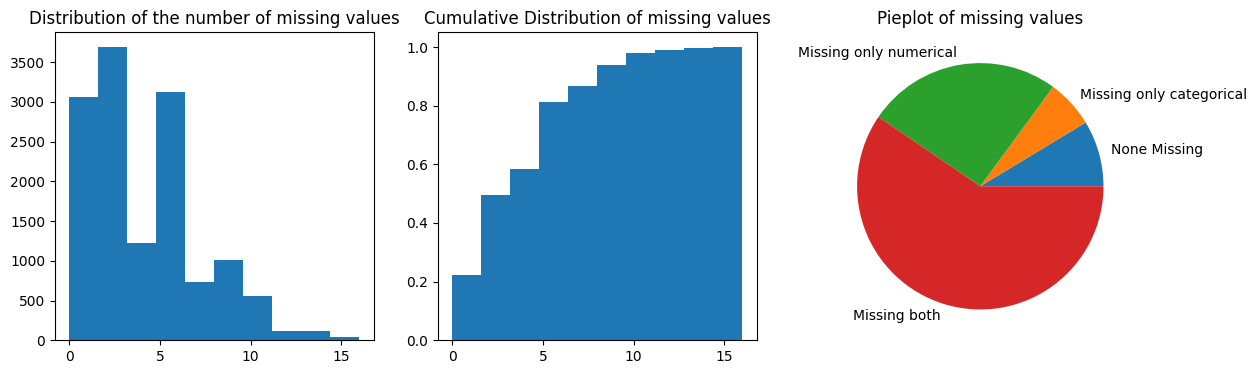

In [25]:
#CREATE USEFUL STRUCTURES TO PLOT THE DISTRIBUTION OF MISSING VALUES
categorical_columns = {}
missing_categorical = np.zeros(len(workdf))
missing_numerical = np.zeros(len(workdf))
missing_count = {}

for col in features:
    if workdf[col].dtype == 'O':  # if the feature is categorical
        workdf[col] = workdf[col].str.lower()  # avoid case-sensitive conflicts
        unique_values = workdf[col].unique()
        categorical_columns[col] = unique_values
        missing_categorical += (workdf[col] == 'not given/unknown').astype(int)
        missing_count[col] = missing_categorical.sum()
    else:
        missing_numerical += workdf[col].isna().astype(int)
        missing_count[col] = missing_numerical.sum()

cat_col_names = list(categorical_columns.keys())
num_col_names = [col for col in features if col not in cat_col_names]

missing = missing_categorical + missing_numerical
missing_categorical_bool = missing_categorical.astype(bool)
missing_numerical_bool = missing_numerical.astype(bool)
none_missing = ~missing_numerical_bool & ~missing_categorical_bool
missing_only_categorical = missing_categorical_bool & ~missing_numerical_bool
missing_only_numerical = missing_numerical_bool & ~missing_categorical_bool
missing_both = missing_categorical_bool & missing_numerical_bool


#VISUAL REPRESENTATION
fig, axs= plt.subplots(1,3)
fig.set_size_inches(14,4)

#HISTOGRAM
axs[0].hist(missing)
axs[0].set_title('Distribution of the number of missing values')
axs[1].hist(missing, cumulative=True, density = True)
axs[1].set_title('Cumulative Distribution of missing values')

#PIEPLOT OF DF ROWS
pie_label = ['None Missing', 'Missing only categorical', 'Missing only numerical', 'Missing both']
pie_data = [none_missing.sum(), missing_only_categorical.sum(), missing_only_numerical.sum(), missing_both.sum()]
axs[2].pie(pie_data, labels = pie_label)
axs[2].set_title('Pieplot of missing values')
plt.grid(linewidth = 1)
plt.show()

##### Analysis of missing values over the rows
The code section below shows that $\approx 90 \% $ of the rows in our dataframe has at least one missing value per row. Removing all of them would be unacceptable for our analysis, since it would cut out the majority of our observations. Therefore, we decide to remove rows with more than *4* missing data (i.e. the $ 20 \% $ of the features) resulting in a reduction of the $\approx 42\%$ of the dataframe.

In [26]:
#COUNT MISSING VALUES FOR EACH ROW
count_one = np.count_nonzero(missing > 0)
print(f'Rows with at least one missing value: {count_one} out of {len(workdf)}, i.e. {round(count_one / len(workdf)*100, 2) } %.'  )

rows_to_remove = missing[missing > 4]
count_five = len(rows_to_remove)
print(f'Rows with at least five missing values: {count_five} out of {len(workdf)}, i.e. {round(count_five / len(workdf)*100, 2) } %.' )

Rows with at least one missing value: 12489 out of 13673, i.e. 91.34 %.
Rows with at least five missing values: 5699 out of 13673, i.e. 41.68 %.


In [27]:
#REMOVE SELECTED ROWS
mask = workdf.index.isin(rows_to_remove.index)
workdf = workdf[~mask]

#UPDATE USEFUL STRUCTURES
missing = missing.drop(rows_to_remove.index)
workdf.replace("not given/unknown", pd.NA, inplace=True)            # Categorical missing values are labeled "not giving/unknown"
missing_count = {}
for col in features:
    missing_count[col] = workdf[col].isna().sum()

#PRINT RESULTS
print(f'Updated DF dimensions: {workdf.shape}')
print(f'There are {(workdf.iloc[:, 5:].isnull().sum(axis=1) > 4).sum()} rows with more than 4 missing features')   # checks if we removed all entries with at least 5 mv for the columns "features"
#print(missing_count)
display(workdf)

Updated DF dimensions: (7974, 25)
There are 0 rows with more than 4 missing features


,Brand,Model,Year,Category,Rating,Displacement (ccm),Power (hp),Torque (Nm),Engine cylinder,Engine stroke,Gearbox,Bore (mm),Stroke (mm),Fuel capacity (lts),Fuel control,Cooling system,Transmission type,Dry weight (kg),Wheelbase (mm),Seat height (mm),Fuel system,Front brakes,Rear brakes,Front tire,Rear suspension
37,adiva,ad 125le,2010,Scooter,1.9,124.0,13.0,10.9,single cylinder,four-stroke,automatic,48.8,57.0,13.5,single overhead cams (sohc),liquid,belt,171.0,1640.0,NaN,carburettor,single disc,single disc,other,other
45,adiva,ad3 300,2019,Scooter,NaN,299.0,29.4,31.0,single cylinder,four-stroke,automatic,72.7,72.0,11.0,single overhead cams (sohc),liquid,<NA>,202.0,1560.0,700.0,injection,single disc,single disc,other,other
48,adiva,ad3 400,2019,Scooter,NaN,399.0,36.7,38.1,single cylinder,four-stroke,automatic,84.0,72.0,11.0,single overhead cams (sohc),liquid,<NA>,257.0,1560.0,770.0,injection,single disc,single disc,other,other
58,adiva,n125,2010,Scooter,NaN,124.0,10.3,9.8,single cylinder,four-stroke,<NA>,52.4,57.8,6.0,single overhead cams (sohc),<NA>,<NA>,108.0,1320.0,800.0,carburettor,single disc,expanding brake (drum brake),120/70-12,<NA>
88,adler,mbs 250 favorit,1959,Allround,NaN,250.0,16.0,NaN,twin,two-stroke,4-speed,54.0,54.0,15.0,<NA>,air,chain,165.0,NaN,NaN,carburettor,expanding brake (drum brake),expanding brake (drum brake),other,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38403,zündapp,k 800,1938,Allround,NaN,791.0,22.0,NaN,four cylinder boxer,four-stroke,4-speed,62.0,66.6,12.5,<NA>,air,shaft drive,193.0,NaN,NaN,carburettor. other,expanding brake (drum brake),expanding brake (drum brake),other,other
38423,zündapp,ks 50 super sport type 517-20,1971,Sport touring,3.7,50.0,6.0,NaN,single cylinder,two-stroke,5-speed,39.0,41.8,9.7,port control,air,chain,84.0,1230.0,NaN,carburettor. other,expanding brake (drum brake),expanding brake (drum brake),other,<NA>
38428,zündapp,ks 601,1950,Allround,NaN,592.0,28.0,NaN,two cylinder boxer,two-stroke,4-speed,75.0,67.6,14.5,overhead valves (ohv),air,shaft drive,224.0,NaN,NaN,carburettor. other,expanding brake (drum brake),expanding brake (drum brake),other,<NA>
38431,zündapp,ks 601,1953,Allround,3.9,592.0,28.0,NaN,two cylinder boxer,two-stroke,4-speed,75.0,67.6,14.5,overhead valves (ohv),air,shaft drive,224.0,NaN,NaN,carburettor. other,expanding brake (drum brake),expanding brake (drum brake),other,<NA>


##### Analysis of missing values over the columns
The following bar plot shows the percentages of missing values for each feature. Firstly, we analyze the numerical features. The graph is highly informative, and allows us to draw some conclusions:
- **Torque (Nm)** has the most missing values among the numerical columns. To decide whether to keep it or not, we think that *Power (Hp)* may represent similar characteristics of a motorcycle. Thus, we print the correlation coefficient of *Torque(Nm)* and *Power (Hp)*. Being the latter $\approx 0.9$, we remove *Torque (Nm)* from the DF columns.
- **Dry weight (kg)** has a lot of missing values as well. Being it an indicator of a motorcycle dimensions, we believe that removing it from our analysis could be a valid choice for two reasons: there are other size indicators such as *Seat height (mm)* and *Wheelbase (mm)* which can do the same job; imputing missing values by replacing them with the mean would increase the error in our analysis, worsening the results.

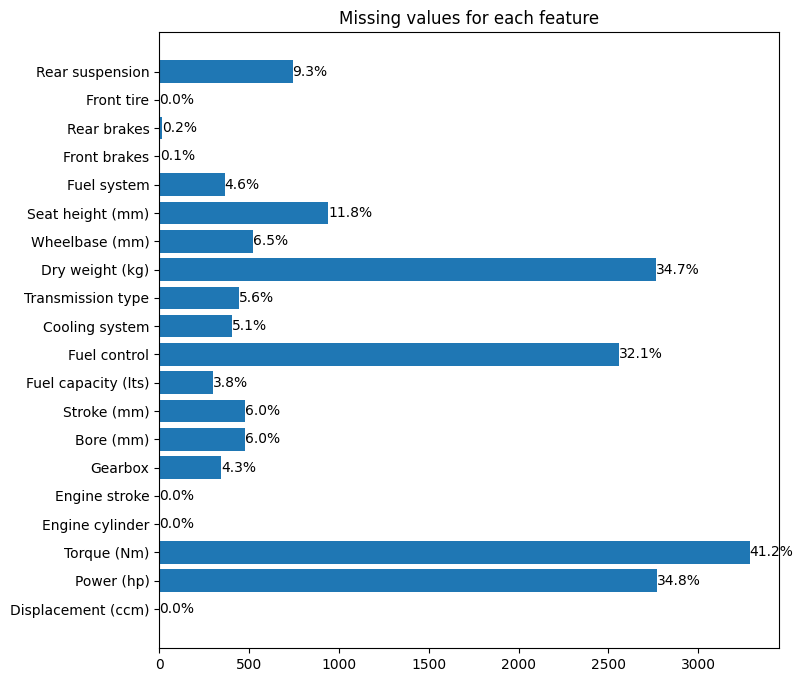

Torque (Nm) and Power (hp) correlation coefficient: 0.891
['Torque (Nm)', 'Dry weight (kg)'] have been deleted from the DataFrame


In [28]:
#BARPLOT: MISSING VALUES FOR EACH FEATURE
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.barh(list(missing_count.keys()), missing_count.values())
ax.set_title('Missing values for each feature')

for i, (key, value) in enumerate(missing_count.items()):            # Add text labels to each bar
    perc = value / len(workdf)
    ax.text(value, i, f'{perc:.1%}', ha='left', va='center')
plt.show()

#ANALYZE TORQUE(Nm)
correlation = workdf['Torque (Nm)'].corr(workdf['Power (hp)'])
print(f'Torque (Nm) and Power (hp) correlation coefficient: {round(correlation, 3)}')

#REMOVE FEATURES
workdf.drop('Torque (Nm)', axis=1, inplace=True)
workdf.drop('Dry weight (kg)', axis = 1, inplace=True)

#REMOVE FROM COLUMN NAMES LISTS
features_to_remove = ['Torque (Nm)', 'Dry weight (kg)']
features = [x for x in features if x not in features_to_remove]
num_col_names = [x for x in num_col_names if x not in features_to_remove]

#PRINT RESULTS
print(f'{features_to_remove} have been deleted from the DataFrame')

Secondly, we analyze the categorical columns. From the graph above we can notice that few features have barely $0.0\%$ of missing values. Thus, we analyze each of the other columns by plotting a histogram of their occurrences, in order to decide how to treat missing values.

In [29]:
#PLOT A HISTOGRAM OF THE CHOSEN COLUMNS
cat_to_inspect = ['Rear suspension', 'Rear brakes', 'Front brakes', 'Fuel system', 'Fuel control', 'Cooling system', 'Transmission type', 'Gearbox']

n_rows = 2
n_cols = 4
n_plots = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 18))

for i, col in enumerate(cat_to_inspect):
    r = i //n_cols
    c = i %n_cols
    ax = axes[r, c]

    #Plot the histogram for the current column
    hist = workdf[col].value_counts(dropna=False).plot(kind='bar', ax=ax)
    #Customize each plot
    yticks = np.arange(0, max(workdf[col].value_counts(dropna=False))+10, 400)
    ax.set_title(col, color = 'green', fontweight = 'bold')  # set title using axis object
    ax.set_xlabel('Category')                                # set x-label using axis object
    ax.set_ylabel('Count')                                   # set y-label using axis object
    ax.set_yticks(yticks)
    ax.grid(True, axis='y', linewidth=0.4, alpha = 0.6)  # add grid lines

    # modify x-axis tick labels
    tick_labels = ax.get_xticklabels()
    new_tick_labels = [label.get_text().replace('not given/unknown', 'NOT GIVEN') for label in tick_labels]
    ax.set_xticklabels(new_tick_labels)

plt.tight_layout()
plt.show()

The graphs above give interesting information about the columns analyzed. Specifically:
1. **Rear suspension** has the majority of the data which are: *other* or *NOT GIVEN* (missing). Thus, we decide to drop the entire column: keeping it into our dataset would increase the complexity of the analysis without giving a valuable contribute.
2. **Rear brakes** and **Front brakes** have a ton of categories, the most of that having very low frequency in our observations. An encoding such as one-hot encoding would only exponentially increase the dimensionality of our dataset, leading to unneeded complexity. For this reason we delete these features from our PCA.
3. **Fuel control** has the $32.1\%$ of data *NOT GIVEN*. Moreover, the remaining $ \approx 68\% $ of data are distributed heterogeneously among 14 categories, which are poorly interpretable and meaningless for our PCA, in our point of view. Therefore, we remove this column from our dataframe, too.
4. **Transmission type** and **Fuel system** are very interesting categories. We decide to keep missing values as a separate instance, combining it with the category *"other"*, when possible.
5. In **Cooling system** and **Gearbox**, along with the not-plotted-here categories **Front tire**, **Engine stroke**, **Engine cylinder** (with $\approx 0\%$ of missing values) we will replace the *NOT GIVEN* values with the mode of the column.

###### ricordati che fuel control è molto correlato con Engine stroke, hanno lo stesso significato praticamente (vedi se scriverlo o meno)

In [30]:
#REMOVE THE REDUNDANT FEATURES
features_to_remove = ['Rear suspension', 'Front brakes', 'Rear brakes', 'Fuel control']
print(features_to_remove)

workdf.drop(columns=features_to_remove, axis=1, inplace=True)

#UPDATE USEFUL STRUCTURES
features = [x for x in features if x not in features_to_remove]             #a list with all column names
cat_col_names = [x for x in cat_col_names if x not in features_to_remove]   #a list with the names of categorical columns
for f in features_to_remove:                                                #the dictionary we use for encoding
    if f in categorical_columns:
        del categorical_columns[f]

#PRINT RESULTS
print("Updated DF dimensions: ", workdf.shape)
workdf.head(10)

['Rear suspension', 'Front brakes', 'Rear brakes', 'Fuel control']
Updated DF dimensions:  (7974, 19)


,Brand,Model,Year,Category,Rating,Displacement (ccm),Power (hp),Engine cylinder,Engine stroke,Gearbox,Bore (mm),Stroke (mm),Fuel capacity (lts),Cooling system,Transmission type,Wheelbase (mm),Seat height (mm),Fuel system,Front tire
37,adiva,ad 125le,2010,Scooter,1.9,124.0,13.0,single cylinder,four-stroke,automatic,48.8,57.0,13.5,liquid,belt,1640.0,NaN,carburettor,other
45,adiva,ad3 300,2019,Scooter,NaN,299.0,29.4,single cylinder,four-stroke,automatic,72.7,72.0,11.0,liquid,<NA>,1560.0,700.0,injection,other
48,adiva,ad3 400,2019,Scooter,NaN,399.0,36.7,single cylinder,four-stroke,automatic,84.0,72.0,11.0,liquid,<NA>,1560.0,770.0,injection,other
58,adiva,n125,2010,Scooter,NaN,124.0,10.3,single cylinder,four-stroke,<NA>,52.4,57.8,6.0,<NA>,<NA>,1320.0,800.0,carburettor,120/70-12
88,adler,mbs 250 favorit,1959,Allround,NaN,250.0,16.0,twin,two-stroke,4-speed,54.0,54.0,15.0,air,chain,NaN,NaN,carburettor,other
129,adly,panther 100,2007,Scooter,NaN,95.6,NaN,single cylinder,two-stroke,automatic,52.0,45.0,6.2,air,<NA>,1240.0,815.0,carburettor. other,120/70-12
138,adly,rt 50 roadtracer,2010,"Minibike, sport",NaN,49.3,NaN,single cylinder,two-stroke,automatic,40.0,39.2,6.2,air,belt,1046.0,NaN,carburettor,other
146,adly,sf-50 silver fox,2010,Scooter,3.4,49.3,3.7,single cylinder,two-stroke,automatic,40.0,39.2,NaN,air,belt,1220.0,NaN,carburettor,other
170,aeon,3d-350,2019,Scooter,NaN,346.0,27.0,single cylinder,four-stroke,automatic,82.0,65.5,13.5,liquid,chain,1565.0,790.0,efi. injection,other
171,aeon,3d-350 r,2019,Scooter,NaN,346.0,30.0,single cylinder,four-stroke,automatic,82.0,65.5,13.5,liquid,chain,1565.0,790.0,efi. injection,other


In [31]:
#DEAL WITH REMAINING MISSING VALUES
# Replace with mode (categorical), with mean (numerical), or remark as another category (other) the remaining columns.
cat_to_replace = ['Engine cylinder', 'Engine stroke', 'Front tire','Cooling system', 'Gearbox']
cat_to_fill = ['Transmission type', 'Fuel system']

for col in cat_to_replace:                              #replace with the mode
     mode = min(workdf[col].mode())
     workdf[col]= workdf[col].fillna(value = mode)

for col in cat_to_fill:                                 #fill with 'other'
    workdf[col] = workdf[col].fillna('other')

for col in num_col_names:                               #replace with the mean
    col_mean = round(workdf[col].mean(),2)
    workdf[col]=workdf[col].fillna(value = col_mean)

rating_mean = round(workdf['Rating'].mean(), 1)
workdf['Rating'] = workdf['Rating'].fillna(value = rating_mean)

workdf.head(10)

,Brand,Model,Year,Category,Rating,Displacement (ccm),Power (hp),Engine cylinder,Engine stroke,Gearbox,Bore (mm),Stroke (mm),Fuel capacity (lts),Cooling system,Transmission type,Wheelbase (mm),Seat height (mm),Fuel system,Front tire
37,adiva,ad 125le,2010,Scooter,1.9,124.0,13.00,single cylinder,four-stroke,automatic,48.8,57.0,13.50,liquid,belt,1640.0,795.26,carburettor,other
45,adiva,ad3 300,2019,Scooter,3.4,299.0,29.40,single cylinder,four-stroke,automatic,72.7,72.0,11.00,liquid,other,1560.0,700.00,injection,other
48,adiva,ad3 400,2019,Scooter,3.4,399.0,36.70,single cylinder,four-stroke,automatic,84.0,72.0,11.00,liquid,other,1560.0,770.00,injection,other
58,adiva,n125,2010,Scooter,3.4,124.0,10.30,single cylinder,four-stroke,6-speed,52.4,57.8,6.00,liquid,other,1320.0,800.00,carburettor,120/70-12
88,adler,mbs 250 favorit,1959,Allround,3.4,250.0,16.00,twin,two-stroke,4-speed,54.0,54.0,15.00,air,chain,1430.6,795.26,carburettor,other
129,adly,panther 100,2007,Scooter,3.4,95.6,59.51,single cylinder,two-stroke,automatic,52.0,45.0,6.20,air,other,1240.0,815.00,carburettor. other,120/70-12
138,adly,rt 50 roadtracer,2010,"Minibike, sport",3.4,49.3,59.51,single cylinder,two-stroke,automatic,40.0,39.2,6.20,air,belt,1046.0,795.26,carburettor,other
146,adly,sf-50 silver fox,2010,Scooter,3.4,49.3,3.70,single cylinder,two-stroke,automatic,40.0,39.2,13.11,air,belt,1220.0,795.26,carburettor,other
170,aeon,3d-350,2019,Scooter,3.4,346.0,27.00,single cylinder,four-stroke,automatic,82.0,65.5,13.50,liquid,chain,1565.0,790.00,efi. injection,other
171,aeon,3d-350 r,2019,Scooter,3.4,346.0,30.00,single cylinder,four-stroke,automatic,82.0,65.5,13.50,liquid,chain,1565.0,790.00,efi. injection,other


## Exercise 2 (Encoding of Categorical Data)
### Section (a)
This section aims to perform a proper encoding of categorical features. To do so, we'll print the categories of each column in order to decide which columns need special encoding. Moreover, we'll assign a color to each column before encoding is computed. This will help us to visualize PCA results and to represent the special encoded columns with a reference to their original category.


In [32]:
#UPDATE DICTIONARY AFTER MV HANDLING
for col in cat_col_names:
    categorical_columns[col] = workdf[col].unique() #append its unique values into a dict entry

#VISUALIZE CATEGORIES FOR EACH FEATURE
for col, unique_values in categorical_columns.items():
    print(f"Column '{col}' has {len(unique_values)} categories:")
    for i, val in enumerate(unique_values):
        print(f"   {i+1}. {val}")

Column 'Engine cylinder' has 14 categories:
   1. single cylinder
   2. twin
   3. v2
   4. four cylinder boxer
   5. v4
   6. diesel
   7. square four cylinder
   8. v8
   9. in-line four
   10. in-line three
   11. two cylinder boxer
   12. in-line six
   13. v6
   14. six cylinder boxer
Column 'Engine stroke' has 4 categories:
   1.  four-stroke
   2.  two-stroke
   3. diesel
   4. square four cylinder
Column 'Gearbox' has 10 categories:
   1. automatic
   2. 6-speed
   3. 4-speed
   4. 1-speed
   5. 5-speed
   6. 3-speed
   7. 2-speed
   8. 10-speed
   9. 7-speed
   10. 100-speed
Column 'Cooling system' has 3 categories:
   1. liquid
   2. air
   3. oil & air
Column 'Transmission type' has 4 categories:
   1. belt
   2. other
   3. chain
   4. shaft drive
Column 'Fuel system' has 7 categories:
   1. carburettor
   2. injection
   3. carburettor. other
   4. efi. injection
   5. efi. carburettor
   6. injection. other
   7. other
Column 'Front tire' has 10 categories:
   1. other
  

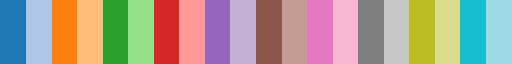

In [33]:
#DEFINE COLORS FOR EACH FEATURE BEFORE CATEGORICAL ENCODING
num_features = len(features) #subtracting the label columns

#define colormap and get the colors
colors = cm.tab20.colors
feature_colors = colors[:num_features]

#create a dictionary: Feature -> color
general_feature_colors = {}
for i in range(num_features):
    general_feature_colors[workdf.iloc[:, 5:].columns[i]] = feature_colors[i]


# SHOWING THE COLORS OF THE CHOSEN COLORMAP
display(cm.tab20)

The only feature needing special encoding $\alpha . \beta \dots$ is **Fuel system**. We perform it using *MultiLabelBinarizer* from the sklearn.preprocessing library.
###### controlla rear e front brakes che ho tolto del tutto
For the other features we perform one hot encoding because we want to avoid an inherent ordering of categories.

In [34]:
#CREATE ANOTHER DATAFRAME TO SAVE THE RESULTS
workdf_encoded = workdf.iloc[:, :5]
special_enc_col = ['Fuel system']
for col in cat_col_names:
    #special encoding
    if col in special_enc_col:
        workdf[col]=[entry.split(sep='. ') for entry in workdf[col]]        #split every entry into list of categories
        mlb = MultiLabelBinarizer(sparse_output=True)                       #initialize a multilabel-binarizer
        mlb_df = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(workdf[col]),                      #perform the multilabel encoding
                                                   index = workdf_encoded.index,
                                                   columns=[col + '_' + c for c in mlb.classes_])       #generate a dataframe from the encoding
        general_feature = col.split('_')[0]
        new_cols = [col + '_' + c for c in mlb.classes_]
        color = general_feature_colors[general_feature]
        for new_col in new_cols:
            general_feature_colors[new_col] = color         #assign a color to the original column

        workdf_encoded=workdf_encoded.join(mlb_df)          #join the mlb dataframe with the final df
    #one-hot encoding
    else:
        workdf_encoded = workdf_encoded.join(pd.get_dummies(workdf[col], prefix=col))   #join the result one-hot df with the final df

# add numerical features (no encoding needed)
for col in num_col_names:
    workdf_encoded = workdf_encoded.join(workdf[col])


### Section (b)
The resulting DF is saved here in the variable *XworkDF*, as requested. The labels, hence the columns from 1 to 5, are instead saved into *LabelsDF* for further usage.

In [35]:
XworkDF = workdf_encoded.iloc[:, 5:]
LabelsDF = workdf_encoded.iloc[:, :5]
print("Updated DF dimensions: ", XworkDF.shape, "\nThe resulting features are: \n", XworkDF.columns)

Updated DF dimensions:  (7974, 56) 
The resulting features are: 
 Index(['Engine cylinder_diesel', 'Engine cylinder_four cylinder boxer',
       'Engine cylinder_in-line four', 'Engine cylinder_in-line six',
       'Engine cylinder_in-line three', 'Engine cylinder_single cylinder',
       'Engine cylinder_six cylinder boxer',
       'Engine cylinder_square four cylinder', 'Engine cylinder_twin',
       'Engine cylinder_two cylinder boxer', 'Engine cylinder_v2',
       'Engine cylinder_v4', 'Engine cylinder_v6', 'Engine cylinder_v8',
       'Engine stroke_ four-stroke', 'Engine stroke_ two-stroke',
       'Engine stroke_diesel', 'Engine stroke_square four cylinder',
       'Gearbox_1-speed', 'Gearbox_10-speed', 'Gearbox_100-speed',
       'Gearbox_2-speed', 'Gearbox_3-speed', 'Gearbox_4-speed',
       'Gearbox_5-speed', 'Gearbox_6-speed', 'Gearbox_7-speed',
       'Gearbox_automatic', 'Cooling system_air', 'Cooling system_liquid',
       'Cooling system_oil & air', 'Transmission type_be

## Exercise 3 (Preprocessing and PCA)
### Section (a)
The following code snippet creates the requested dataframes, used to scale data. In *Xworkdf_std* we use StandardScaler while *Xworkdf_mm* contains data scaled with MinMaxScaler.

In [36]:
data_mat = XworkDF.to_numpy()

#STANDARD SCALE
scaler_std = StandardScaler()
Xworkdf_std = pd.DataFrame(scaler_std.fit_transform(data_mat), index=XworkDF.index, columns=XworkDF.columns)

#MIN-MAX SCALE
scaler_mm = MinMaxScaler()
Xworkdf_mm = pd.DataFrame(scaler_mm.fit_transform(data_mat), index=XworkDF.index, columns=XworkDF.columns)


### Section (b)
In the following, the variance of numerical features, one for each dataframe is computed. After this we plot results and draw conclusions.

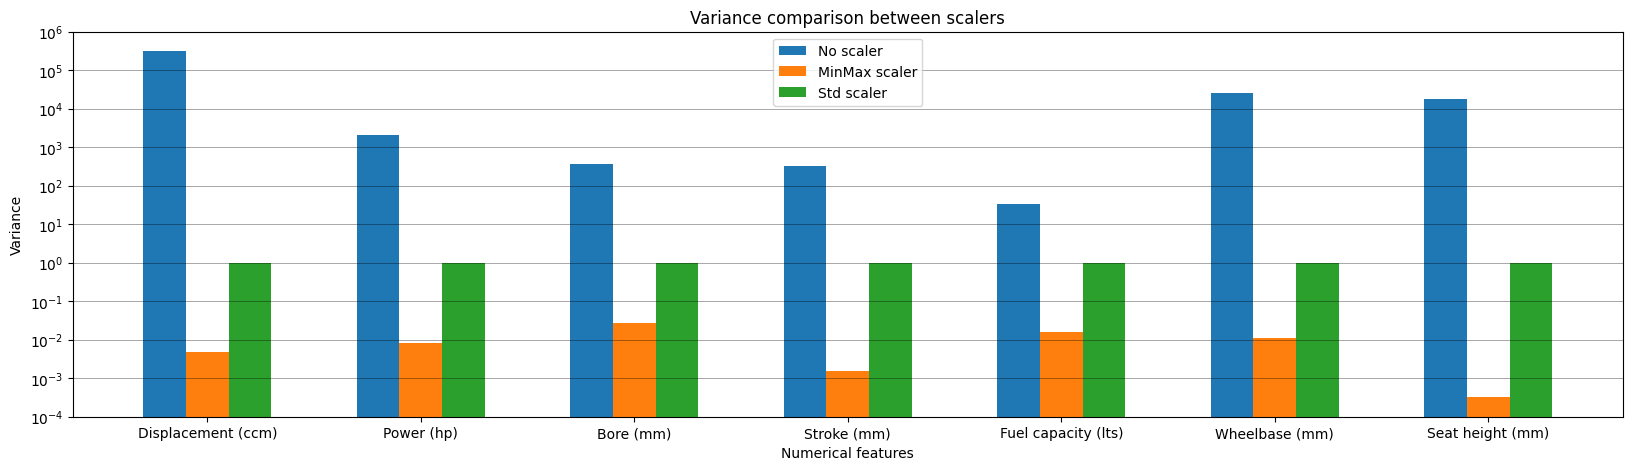

In [37]:
#VARIANCE COMPUTATION
var_numerical = np.array(XworkDF[num_col_names].var())
var_numerical_mm = np.array(Xworkdf_mm[num_col_names].var())
var_numerical_std = np.array(Xworkdf_std[num_col_names].var())

#VISUALIZE RESULTS
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
labels = [l for l in num_col_names]
X_axis = np.arange(len(num_col_names))
bar1 = ax.bar(X_axis-0.2, var_numerical, 0.2, label = 'No scaler')
bar2 = ax.bar(X_axis, var_numerical_mm, 0.2, label = 'MinMax scaler')
bar3 = ax.bar(X_axis+0.2, var_numerical_std, 0.2, label = 'Std scaler')

#ADJUST PLOTS
ax.set_ylabel('Variance')
ax.set_yscale('log')
ax.set_title('Variance comparison between scalers')
ax.set_xlabel('Numerical features')
ax.set_xticks(X_axis)
ax.set_yticks(ticks= np.logspace(-4, 6, 11))
ax.set_xticklabels(labels)
ax.grid(axis='y', linewidth=0.6, alpha = 0.4)
ax.legend()
plt.show()

##### TODO commentare

### Section (c)
PCA is performed on the three dataframes. The full PCA takes into account  all the columns of our DFs and extracts the principal components obtained as a linear combination of the latter.

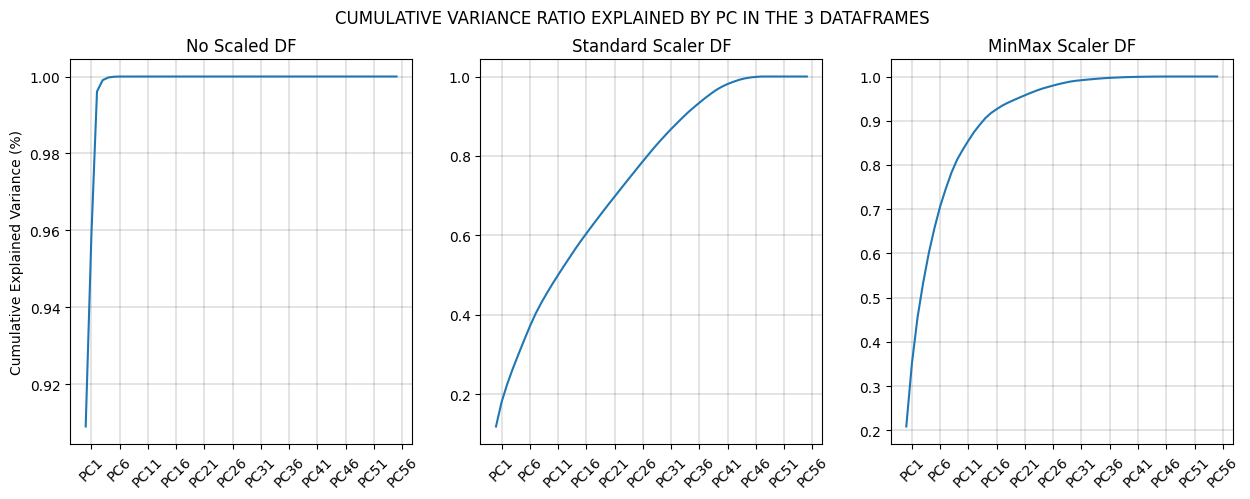

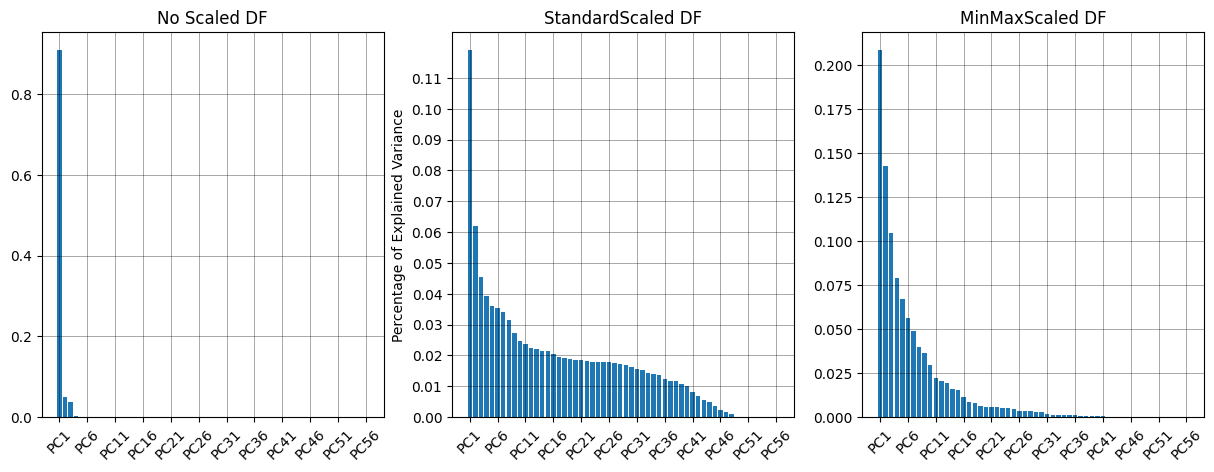

In [45]:
#INITIALIZE THE PCA
pca_full_noscale = PCA()
pca_full_mm = PCA()
pca_full_std = PCA()

#FIT OUR DATAFRAMES
pca_full_noscale.fit(np.array(XworkDF))
pca_full_std.fit(np.array(Xworkdf_std))
pca_full_mm.fit(np.array(Xworkdf_mm))

#EXPLAINED VARIANCE
expl_var_noscale = pca_full_noscale.explained_variance_ratio_
expl_var_mm = pca_full_mm.explained_variance_ratio_
expl_var_std = pca_full_std.explained_variance_ratio_

#VISUALIZE THE RESULTS
#plot of the cumulative variance
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,5)
fig.suptitle('CUMULATIVE VARIANCE RATIO EXPLAINED BY PC IN THE 3 DATAFRAMES')
#No scale
axs[0].plot(expl_var_noscale.cumsum())
axs[0].set_title('No Scaled DF')
axs[0].set_ylabel('Cumulative Explained Variance (%)')
axs[0].set_xticks(ticks = np.arange(1, pca_full_noscale.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_noscale.n_features_in_+1, 5)],
           rotation=45)
axs[0].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)
#Standard Scaler
axs[1].plot(expl_var_std.cumsum())
axs[1].set_title('Standard Scaler DF')
axs[1].set_xticks(ticks = np.arange(1, pca_full_std.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_std.n_features_in_+1, 5)],
           rotation=45)
axs[1].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)
#Min-Max Scaler
axs[2].plot(expl_var_mm.cumsum())
axs[2].set_title('MinMax Scaler DF')
axs[2].set_xticks(ticks = np.arange(1, pca_full_mm.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_mm.n_features_in_+1, 5)],
           rotation=45)
axs[2].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)
plt.show()

#bar plot representing the variance explained by each PC
#No scale
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,5)
axs[0].bar(range(1, len(expl_var_noscale) + 1), expl_var_noscale, align='center')
axs[0].set_xticks(ticks = np.arange(1, pca_full_noscale.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_noscale.n_features_in_+1, 5)], rotation=45)
axs[0].set_title('No Scaled DF')
axs[0].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
#Standard Scaler
axs[1].set_title('StandardScaled DF')
axs[1].set_ylabel('Percentage of Explained Variance')
axs[1].bar(range(1, len(expl_var_std) + 1), expl_var_std, align='center')
axs[1].set_xticks(ticks = np.arange(1, pca_full_std.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_std.n_features_in_+1, 5)], rotation=45)
axs[1].set_yticks(np.arange(0, expl_var_std[0], 0.01))
axs[1].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
#Min-Max Scaler
axs[2].bar(range(1, len(expl_var_mm) + 1), expl_var_mm, align='center')
axs[2].set_xticks(ticks = np.arange(1, pca_full_mm.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_mm.n_features_in_+1, 5)], rotation=45)
axs[2].set_title('MinMaxScaled DF')
axs[2].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
plt.show()

As we can notice from the graphs above, the no scaled dataset is almost all explicable by the first 3 principal components. This happens because there are numerical features whose values are distributed over very large intervals, e.g. **Displacement (ccm)** has values from $250$ to $82770$. Such an analysis does not work properly. Instead, standard scaler ......
##### finire di commentare cerca su chatgpt

## Exercise 4. (Dimensionality Reduction and Interpretation of the PCs
### Section (a)
Let's find the number of principal components explaining at least the 35% of the total variance. According to the suggestions, we select m features that satisfy  m = min\{m_(35\%), 5}. We notice that, in the StandardScaler DF, 5 components are not enough to cover the $35\%$ of variance, but at least 7 are needed. In the MinMax Scaled DF, instead, we need 2 PCs.

1 2


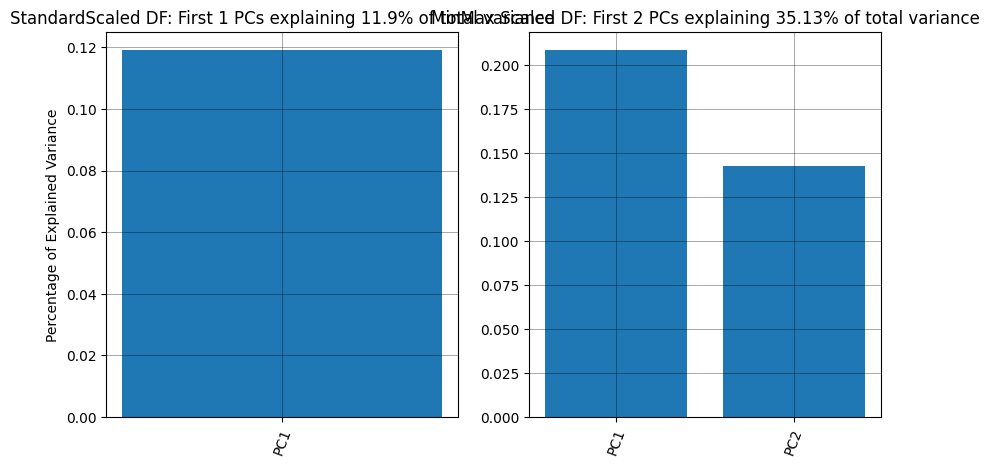

In [47]:
#choosing m
m_prime_std = np.argmax(np.cumsum(expl_var_std) >= 0.35) + 1
m_prime_mm = np.argmax(np.cumsum(expl_var_mm) >= 0.35) + 1
print(m_prime_std, m_prime_mm)
m_std = min(m_prime_std, 5)
m_mm = min(m_prime_mm, 5)

#perform PCA using the first m choosen principal component only
# INITIALIZE THE PCA
pca_m_std = PCA(n_components=m_std)
pca_m_mm = PCA(n_components=m_mm)

# FIT THE PCA
Ystd_df = pca_m_std.fit_transform(Xworkdf_std)
Ymm_df = pca_m_mm.fit_transform(Xworkdf_mm)
#barplots of the variance explained

expl_var_std = pca_m_std.explained_variance_ratio_
expl_var_mm = pca_m_mm.explained_variance_ratio_

#STANDARD SCALER
round_expl_var_ratio = np.round(expl_var_std.sum() * 100, 2)
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
axs[0].bar(range(1, m_std + 1), expl_var_std[:m_std], align='center')
axs[0].set_title(f"StandardScaled DF: First {format(m_std)} PCs explaining {round_expl_var_ratio}% of total variance")
axs[0].set_xticks(ticks= range(1, m_std + 1), labels = [f'PC{i}' for i in range(1, m_std+1)], rotation=70)
axs[0].set_ylabel('Percentage of Explained Variance')
axs[0].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)

#MINMAX SCALER
round_expl_var_ratio = np.round(expl_var_mm.sum() * 100, 2)
axs[1].bar(range(1, m_mm + 1), expl_var_mm[:m_mm], align='center')
axs[1].set_title(f"MinMax Scaled DF: First {format(m_mm)} PCs explaining {round_expl_var_ratio}% of total variance")
axs[1].set_xticks(ticks= range(1, m_mm + 1), labels = [f'PC{i}' for i in range(1, m_mm+1)], rotation=70)
axs[1].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)

plt.show()

### Section (b)
Loading graph for the 5 principal component to interpret results. For each PC, we will print a barplot showing the contribute o each feature of the top 20 selected. Moreover, for each PC, the feature with greatest contribute w.r.t. to the threshold $\epsilon = \sqrt{1/n}$ ($n$ is the number of features) will be selected to interpret the meaning of the PCs.

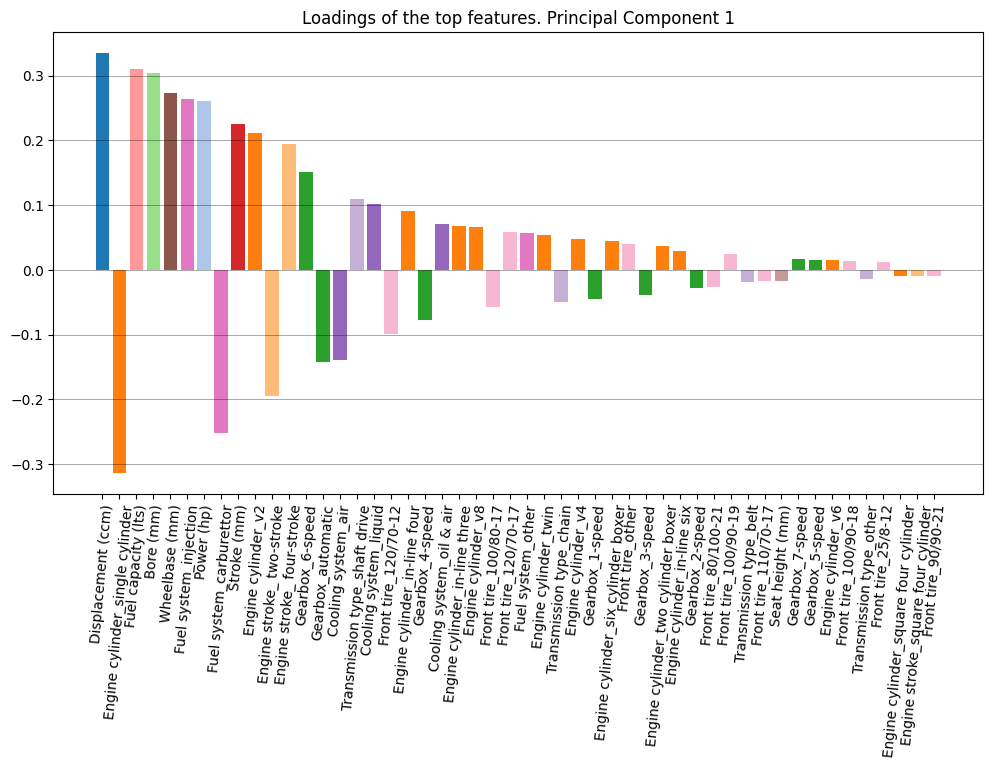

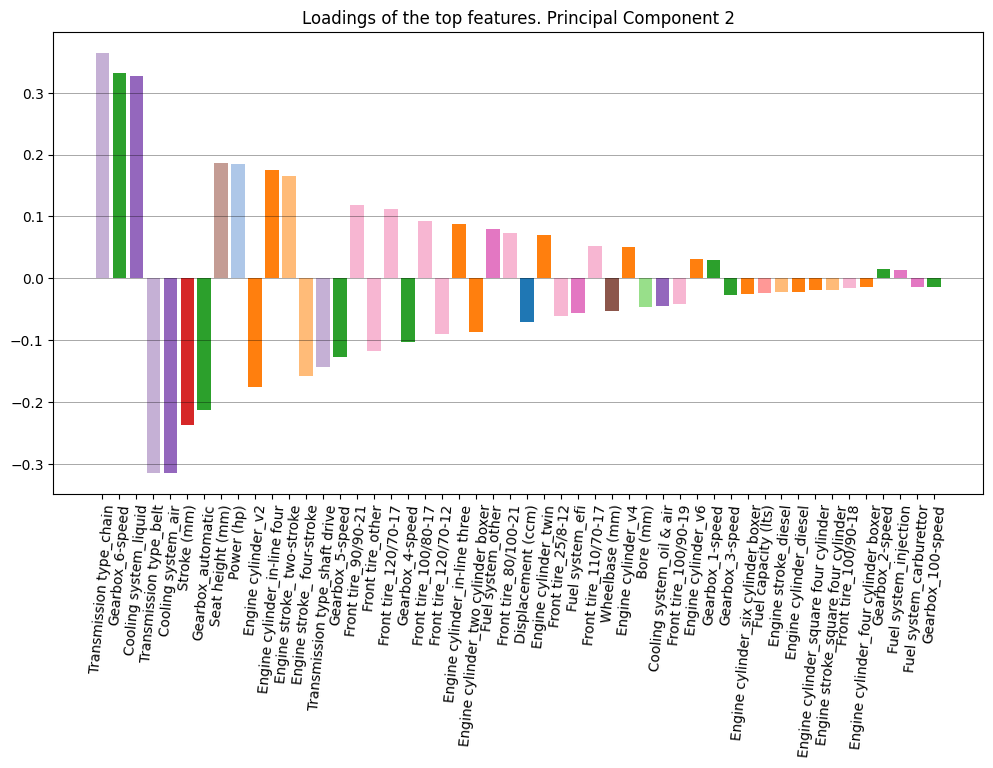

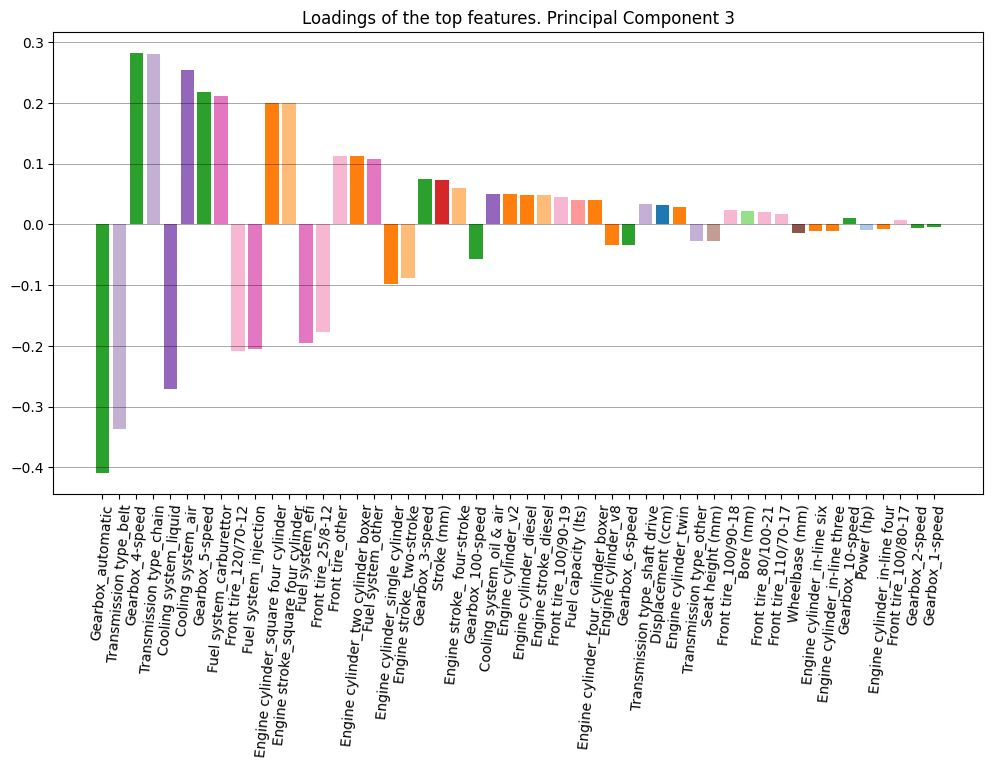

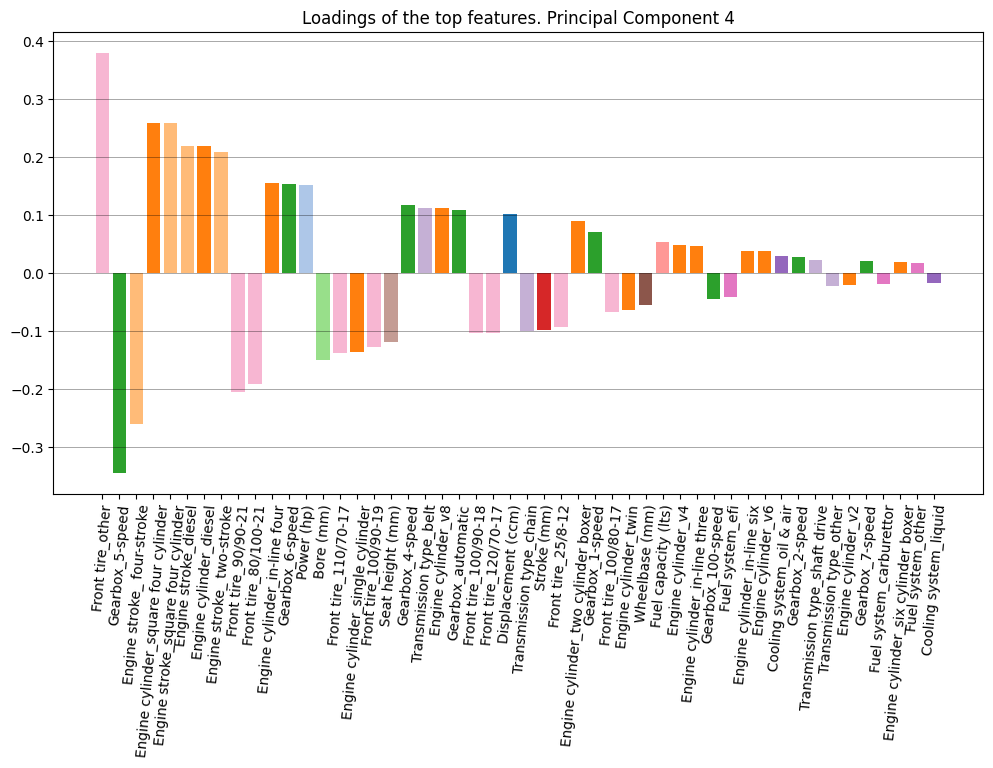

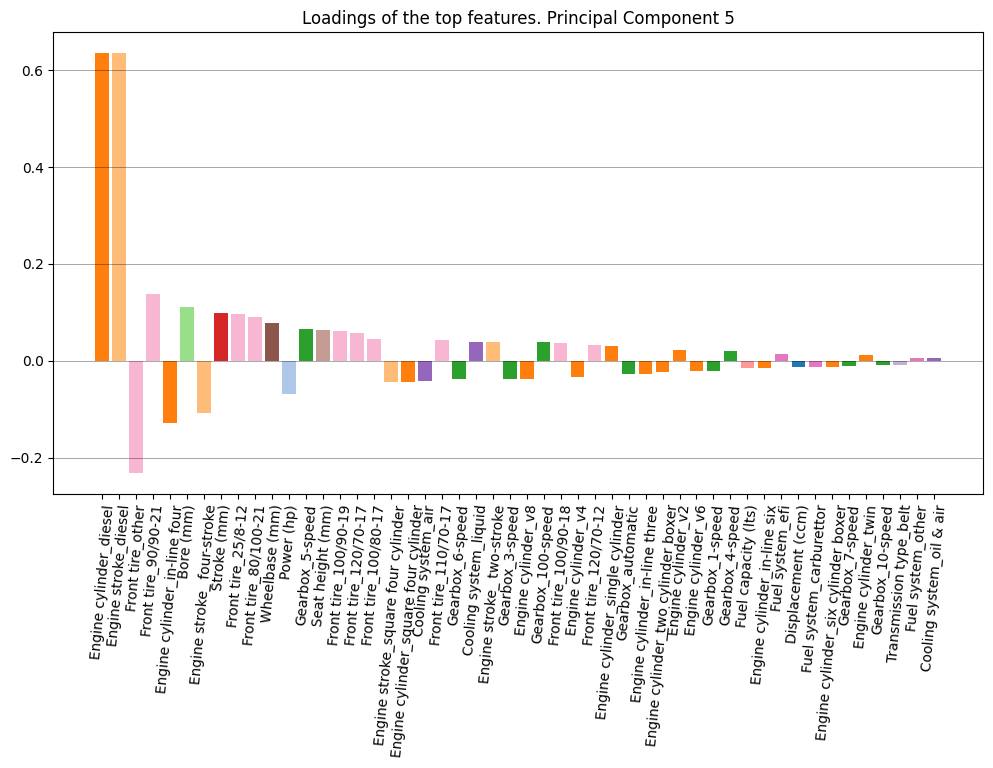

Results on StandardScaled DF for the first 5 PCs
Top 4 features for PC1: ['Displacement (ccm)', 'Engine cylinder_single cylinder', 'Fuel capacity (lts)', 'Bore (mm)']
Top 4 features for PC2: ['Transmission type_chain', 'Gearbox_6-speed', 'Cooling system_liquid', 'Transmission type_belt']
Top 4 features for PC3: ['Gearbox_automatic', 'Transmission type_belt', 'Gearbox_4-speed', 'Transmission type_chain']
Top 4 features for PC4: ['Front tire_other', 'Gearbox_5-speed', 'Engine stroke_ four-stroke', 'Engine cylinder_square four cylinder']
Top 4 features for PC5: ['Engine cylinder_diesel', 'Engine stroke_diesel', 'Front tire_other', 'Front tire_90/90-21']


In [40]:
#here I'll print some tries to show which features are the best performing in my model
n_topfeatures = 50
#StandardScaler model PCA
#get the loadings of each feature for each pc of the m selected
loadings = pca_m_std.components_#* np.sqrt(expl_var_std[:m_std])
topfeat_std = [] #this is an array of list: i stands for the i-th PC, and the cell is a ordered list of the 5 best influencing feature for that PC
for i in range(m_std):
    # Sort the loadings for the current component in descending order
    component_loadings = loadings[i]
    sorted_loadings = sorted(enumerate(component_loadings), key=lambda x: -abs(x[1]))
    #extract the n top features and save them in a list
    top_feature_indices = [index for index, _ in sorted_loadings[:n_topfeatures]]
    top_features_for_component = list(Xworkdf_std.columns[top_feature_indices])
    topfeat_std.append(top_features_for_component)
    #plot the barplot
    fig, ax = plt.subplots(figsize=(12,6))
    #using the general feature color to set the color of each bar
    feature_colors = [general_feature_colors[c.split('_')[0]] for c in top_features_for_component]
    ax.bar(top_features_for_component, component_loadings[top_feature_indices], color=feature_colors)
    ax.set_title(f'Loadings of the top features. Principal Component {i+1}')
    ax.tick_params(axis='x', rotation=85)
    ax.grid(axis='y', linewidth=0.4, alpha = 0.6)
    plt.show()


#print the top features for each component
print(f"Results on StandardScaled DF for the first {m_std} PCs")
for i in range(m_std):
    print(f"Top 4 features for PC{i+1}: {topfeat_std[i][:4]}")

## Interpreting results:
PC1: **power and performance** being displacement, double disc of positive loading while single cylinder of negative loading, indicator of a less powerful technology
PC2: **Fuel and cooling system variations**. (vedi chatgpt) A principal component with a high loading for this feature might indicate that there is variability in the available information about the motorcycles in the dataset.
PC3: It seems like this principal component captures a contrast between motorcycles with modern automatic transmissions and belt drive systems, versus those with chain drive systems and an unknown fuel system. Potentially call this component something like **Modern Drive Systems** or **Drivetrain Technology**. The negative loading for "Fuel system_unknown" suggests that this component may be more strongly related to the type of drivetrain technology than the fuel system.
PC4: **Braking System Sophistication**
PC5: **Electric Power** or **Electric Propulsion**.





In [41]:
#GIVING NAMES TO THE PCA COMPONENTS ACCORDING TO LOADINGS

pc_std_names =['Power and performance',
                'Air [+] VS Liquid [-] Cooling system',
                'Drivetrain Technology',
                'Braking System Sophistication',
                'Electric[+] VS Combustion [-] systems']


 ## MinMax scaler results

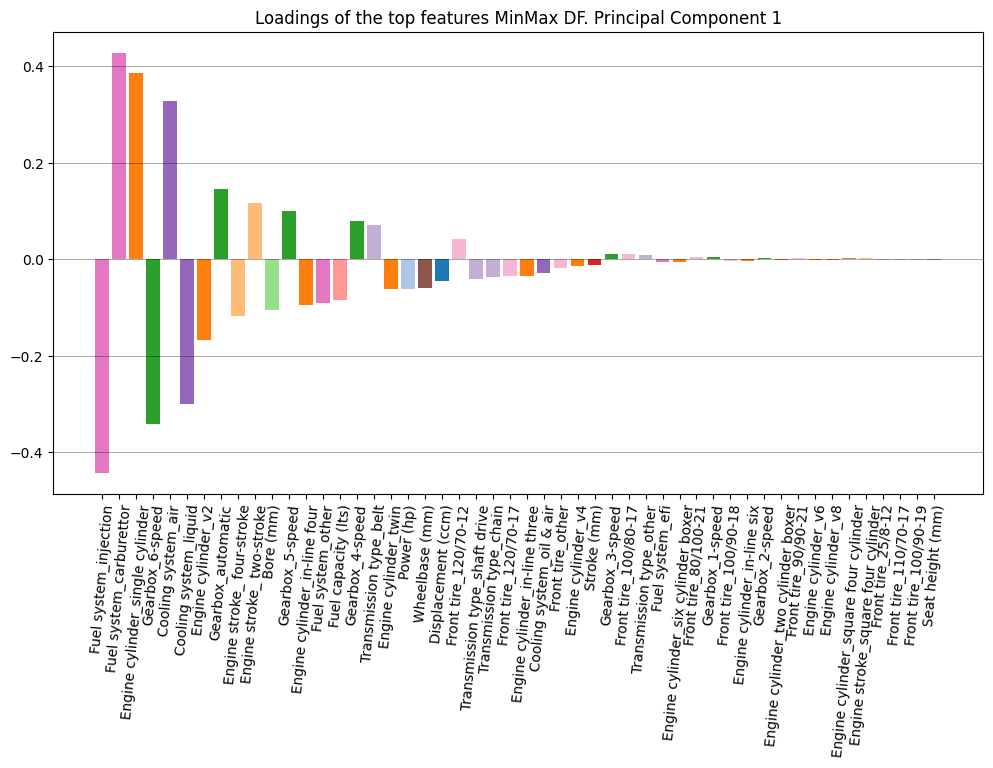

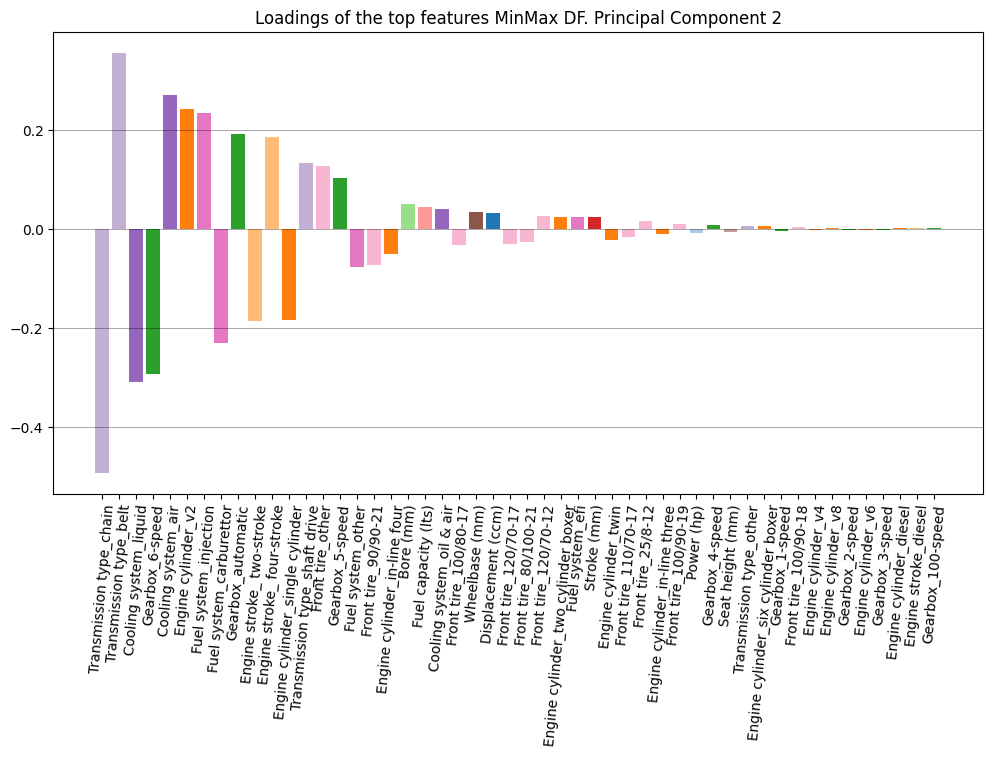


Results on MinMaxScaled DF for the first 2 PCs
Top 5 features for PC1: ['Fuel system_injection', 'Fuel system_carburettor', 'Engine cylinder_single cylinder', 'Gearbox_6-speed', 'Cooling system_air']
Top 5 features for PC2: ['Transmission type_chain', 'Transmission type_belt', 'Cooling system_liquid', 'Gearbox_6-speed', 'Cooling system_air']


In [42]:
#MinMax Scaler model PCA
#get the loadings of each feature for each pc of the choosen m
loadings = pca_m_mm.components_
                                        #.T * np.sqrt(expl_var_std[:m_mm])
topfeat_mm = []
for i in range(m_mm):
    # Sort the loadings for the current component in descending order
    component_loadings = loadings[i]
    #sorting loadings of each feature for the i-th pc according to the function: -absolute value of the loading (- is for guaranteeing descending order)
    sorted_loadings = sorted(enumerate(component_loadings), key=lambda x: -abs(x[1]))
    #extract the n top features and save them in a list
    top_feature_indices = [index for index, _ in sorted_loadings[:n_topfeatures]]
    #questo crea una lista con le top features per la comp. princ. i=1,2,3 (PC1, PC2, PC3 una per loop) con i nomi delle colonne dal dataset a seconda degli indici
    top_features_for_component = list(Xworkdf_mm.columns[top_feature_indices])
    topfeat_mm.append(top_features_for_component)

    #plot the barplot
    fig, ax = plt.subplots(figsize=(12,6))
    #using the general feature color to set the color of each bar
    feature_colors = [general_feature_colors[c.split('_')[0]] for c in top_features_for_component]
    ax.bar(top_features_for_component, component_loadings[top_feature_indices], color=feature_colors)
    ax.set_title(f'Loadings of the top features MinMax DF. Principal Component {i+1}')
    ax.tick_params(axis='x', rotation=85)
    ax.grid(axis='y', linewidth=0.4, alpha =0.6)
    plt.show()

print(f"\nResults on MinMaxScaled DF for the first {m_mm} PCs")
#print the top features for each component
for i in range(m_mm):
    print(f"Top 5 features for PC{i+1}: {topfeat_mm[i][:5]}")

## Interpreting results:
PC1: **performance** being the first two and the fourth feature positively associated to the PC1, while cooling system_air is negatively associated, this PC can represent the motorcycle performance or power where air cooling is an indicator of worse performance.
PC2: simpler, basic model (**traditional style** motorcycle)
PC3: belt-driven automatic transmission system, we can say **automatic motorcycle**

In [43]:
#GIVING NAMES TO THE PCA COMPONENTS ACCORDING TO LOADINGS

pc_mm_names =['Performance and power',
              'Cost-effectiveness and simplicity',
              'Chain (Off-road) vs Belt (Touring)']  #vedi chatgpt PCA interpretation MM


############### NOTES ABOUT THE ORDERING LOADINGS PART #############
the line sorted loadings sorts the loadings in descending order of their absolute values. This is done by first creating a list of tuples, where each tuple contains the index of a feature and its corresponding loading (i.e., enumerate(component_loadings)). The key argument of the sorted function specifies the function used to determine the sort order. In this case, the key function is lambda x: -abs(x[1]), which returns the negative absolute value of the loading. By taking the negative, we ensure that the loadings are sorted in descending order. By taking the absolute value, we ensure that the sort order is based on the magnitude of the loadings, rather than their sign.

## Score graph w.r.t. the first 3 PCs

In [ ]:
#StandardScaled Dataframe. ScatterPlot with all the 1st 3 PCs

fig_3d = plt.figure(figsize=(8, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(Ystd_df[:, 0], Ystd_df[:, 1], Ystd_df[:, 2], s=2, alpha = 0.6)
#ax_3d.set_box_aspect((1, 1, 1))
plt.title('MOTORCYCLE STANDARD SCALED DF. SCORE GRAPH')
ax_3d.set_xlabel(pc_std_names[0])
ax_3d.set_ylabel(pc_std_names[1])
ax_3d.set_zlabel(pc_std_names[2])

ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)
# for line in ax_3d.xaxis.get_gridlines() + ax_3d.yaxis.get_gridlines() + ax_3d.zaxis.get_gridlines():
#     line.set_linestyle(':')
#     line.set_color('gray')
#     line.set_linewidth(0.5)
#     line.set_alpha(0.6)
plt.show()




In [ ]:
#Min-Max Dataframe. ScatterPlot with all the 1st 3 PCs

fig_3d = plt.figure(figsize=(8, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(Ymm_df[:, 0], Ymm_df[:, 1], Ymm_df[:, 2], s=2, alpha = 0.6)
ax_3d.set_box_aspect((1, 1, 1))
plt.title('MOTORCYCLE MIN-MAX SCALED DF. SCORE GRAPH')
ax_3d.set_xlabel(pc_mm_names[0])
ax_3d.set_ylabel(pc_mm_names[1])
ax_3d.set_zlabel(pc_mm_names[2])
ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)

plt.show()


######### here we need to complete exercise 5 #########
TO DO:
-upgrade scatter plot for STD_DF -> colors wrt category

TO DO #2: MINMAX_DF creation and same things for the STD_DF

In [ ]:
##### IN THIS CELL MORE SCORE GRAPHS WILL BE PLOTTED WRT BRANDS AND CATEGORIES ######

#categories plotting

colors1 = cm.tab20.colors

display(cm.tab20)

categories = LabelsDF['Category'].unique()
#brands = LabelsDF['Brand'].unique()
#print(list(brands))
#dictionary assigning a color to each category

categories_colors = {categories[i]: colors1[i] for i in range(len(categories))}
#brands_colors = {brands[i]: colors2[i] for i in range(len(brands))}

##add the color columns to the Labels DF
LabelsDF['Category Color'] = [categories_colors[i] for i in LabelsDF['Category'].values]
#LabelsDF['Brand Color'] = [brands_colors[i] for i in LabelsDF['Brand']]


#make a custom legend for colors

categories_colors_legend = [Line2D([0], [0], color=categories_colors[k]) for k in categories_colors.keys()]

#STANDARD SCALED DATAFRAME
#make the 3d colored graph
fig_3d = plt.figure(figsize=(10,10))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(Ystd_df[:, 0], Ystd_df[:, 1], Ystd_df[:, 2], s=2,  c = LabelsDF['Category Color'].values, alpha = 0.6)
ax_3d.set_box_aspect((1, 1, 1))
plt.title('STD SCALED DF. CATEGORIES SCORE GRAPH')
ax_3d.set_xlabel(pc_std_names[0])
ax_3d.set_ylabel(pc_std_names[1])
ax_3d.set_zlabel(pc_std_names[2])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
ax_3d.view_init(elev=20, azim=-160)
#ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)

plt.show()


In [ ]:
plt.figure()
plt.scatter(Ystd_df[:, 0], Ystd_df[:, 1], s=3, c=LabelsDF['Category Color'].values, alpha=0.9)
plt.title('MOTORCYCLE CATEGORIES (STD DF) - SCORE GRAPH (ON R^2)')
plt.xlabel(pc_std_names[1])
plt.ylabel(pc_std_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.show()

In [ ]:
#MINMAX SCALED DATAFRAME
#make the 3d colored graph
fig_3d = plt.figure(figsize=(10,10))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(Ymm_df[:, 0], Ymm_df[:, 1], Ymm_df[:, 2], s=2,  c = LabelsDF['Category Color'].values, alpha = 0.6)
ax_3d.set_box_aspect((1, 1, 1))
plt.title('MINMAX SCALED DATA. SCORE GRAPH WRT CATEGORIES')
ax_3d.set_xlabel(pc_mm_names[0])
ax_3d.set_ylabel(pc_mm_names[1])
ax_3d.set_zlabel(pc_mm_names[2])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
ax_3d.view_init(elev=50, azim=120)
#ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)

plt.show()

In [ ]:
plt.figure()
plt.scatter(Ymm_df[:, 0], Ymm_df[:, 2], s=3, c=LabelsDF['Category Color'].values, alpha=0.9)
plt.title('MOTORCYCLE CATEGORIES -MINMAX SCORE GRAPH (ON R^2)')
plt.xlabel(pc_mm_names[0])
plt.ylabel(pc_mm_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.show()

In [ ]:
#3d score graph according to the "YEAR"label. This is to show improvements made thorough the years about the first principal components

In [ ]:
sg_year = plt.figure(figsize=(10,10))
ax_3d_year = sg_year.add_subplot(111, projection='3d')
year_scatter = ax_3d_year.scatter(Ystd_df[:, 0], Ystd_df[:, 1], Ystd_df[:, 2], s=3, c=LabelsDF['Year'].values, cmap='gist_heat', alpha=0.8)
plt.title('MOTORCYCLE YEAR (STD DF) - SCORE GRAPH ')
ax_3d_year.set_xlabel(pc_std_names[0])
ax_3d_year.set_ylabel(pc_std_names[1])
ax_3d_year.set_zlabel(pc_std_names[2])
plt.colorbar(year_scatter)
ax_3d_year.view_init(elev=10, azim=-60)
ax_3d_year.grid(False)
plt.show()

In [ ]:
sg_year = plt.figure(figsize=(10,10))
ax_3d_year = sg_year.add_subplot(111, projection='3d')
year_scatter = ax_3d_year.scatter(Ymm_df[:, 0], Ymm_df[:, 1], Ystd_df[:, 2], s=4, c=LabelsDF['Rating'].values, cmap='RdBu', alpha=1)
plt.title('MOTORCYCLE YEAR (MINMAX DF) - SCORE GRAPH ')
ax_3d_year.set_xlabel(pc_mm_names[0])
ax_3d_year.set_ylabel(pc_mm_names[1])
ax_3d_year.set_zlabel(pc_mm_names[2])
plt.colorbar(year_scatter)
ax_3d_year.view_init(elev=40, azim=70)
ax_3d_year.grid(False)
plt.show()

### Exercise 5 (k-Means)

In [ ]:
#Performing k-means with k in [3,10]
km_list = []
silcoeff_list_std = []
k_list = list(range(3, 11))
# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT

print(f'KMEANS ALGORTHM ON STANDARD-SCALED DATAFRAME')
for i in range(len(k_list)):
    print(f'Computing with k={k_list[i]}...')
    km_list.append(KMeans(n_clusters=k_list[i], n_init=3, random_state=rs))
    km = km_list[i]
    km.fit(Ystd_df)
    silcoeff_list_std.append(silhouette_score(Ystd_df, km.labels_))
    print(f'***************')
    print('')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_std = np.argmax(silcoeff_list_std)
k_std = k_list[i_best_std]
km_std = km_list[i_best_std]

# VISUALIZE THE RESULT
print('\nRESULTS OF THE SEARCH')
print(f'Best silhouette score for StandardScaled DF: {np.max(silcoeff_list_std)} with k = {k_std}')


In [ ]:
print(silcoeff_list_std)

In [ ]:
###THESE ARE THE DEFAULT PARAMETERS OF KMEANS####
#ONLY ALGORITHM IS DIFFERENT: DEFAULT IS LLOYD
#KMeans(n_clusters=8, init="k-means++", n_init="warn", max_iter=300, tol=1e-4, verbose=(), random_state=None, copy_x=True, algorithm="elkan")
#KMeans()

In [ ]:
#######MIN MAX SCALED DATAFRAME########
#Performing k-means with k in [3,10]
km_list = []
silcoeff_list_mm = []
k_list = list(range(3, 11))
# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT

print(f'KMEANS ALGORTHM ON MIN-MAX-SCALED DATAFRAME')
for i in range(len(k_list)):
    print(f'k={k_list[i]}\n')
    print('Computing...')
    km_list.append(KMeans(n_clusters=k_list[i], n_init=3, random_state=rs))
    km = km_list[i]
    km.fit(Ymm_df)
    silcoeff_list_mm.append(silhouette_score(Ymm_df, km.labels_))
    print(f'***************\n')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_mm = np.argmax(silcoeff_list_mm)
k_mm = k_list[i_best_mm]
km_mm = km_list[i_best_mm]

# VISUALIZE THE RESULT
print('\nRESULTS OF THE SEARCH')
print(f'Best silhouette score for StandardScaled DF: {np.max(silcoeff_list_mm)} with k = {k_mm}')




Optional: exercise 5. Playing with the parameters of the function KMeans. (max_iter and algorithm type)

In [ ]:
# #Playing with other parameters for k-means. at first let's modify the number of iterations to see when the algorithm converges
# #STANDARD SCALED DATAFRAME
# km_list = []
# silcoeff_list_mm = []
# k_list = list(range(3, 11))
#
# print(f'KMEANS ALGORITHM ON MIN-MAX-SCALED DATAFRAME')
#
# for n_iter in range(1, 51):
#     print(f'n_iter={n_iter}')
#     km_list.append([])
#     silcoeff_list_mm.append([])
#     for i in range(len(k_list)):
#         print(f'k={k_list[i]}')
#         print('Computing...')
#         km_list[n_iter-1].append(KMeans(n_clusters=k_list[i], n_init=3, max_iter=n_iter, random_state=rs))
#         km = km_list[n_iter-1][i]
#         km.fit(Ymm_df)
#         silcoeff_list_mm[n_iter-1].append(silhouette_score(Ymm_df, km.labels_))
#         # print(f'n_iter={n_iter}, k={k_list[i]}, n_iter_={km.n_iter_}, sil_score={silcoeff_list_mm[n_iter-1][-1]}')
#         # print('***************')
#
# # FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
# i_best_mm, j_best_mm = np.unravel_index(np.argmax(silcoeff_list_mm), np.shape(silcoeff_list_mm))
# k_mm = k_list[i_best_mm]
# n_iter_mm = j_best_mm + 1
# km_mm = km_list[n_iter_mm-1][i_best_mm]
#
# # VISUALIZE THE RESULT
# print('\nRESULTS OF THE SEARCH')
# print(f'Best silhouette score for Min-Max Scaled DF: {np.max(silcoeff_list_mm)} with k={k_mm}, n_iter={n_iter_mm}, and n_iter_={km_mm.n_iter_}')
#


In [ ]:
### STD SCALED DATASET.
#let's see how many iterations are needed to converge.

# define the range of k and n_iter values to test
k_list = list(range(3, 11))
n_iter_list = list(range(1, 51))

# create empty arrays to store the silhouette scores and best k values
silhouette_scores = np.zeros((len(k_list), len(n_iter_list)))
best_k_values = np.zeros(len(n_iter_list))

# loop over the n_iter values
for j, n_iter in enumerate(n_iter_list):
    print(f'n_iter={n_iter}')
    sil_scores = []
    k_values = []
    # loop over the k values
    for i, k in enumerate(k_list):
        km = KMeans(n_clusters=k, n_init=3, max_iter=n_iter, random_state=0)
        km.fit(Ymm_df)
        sil_score = silhouette_score(Ymm_df, km.labels_)
        sil_scores.append(sil_score)
        k_values.append(k)
    silhouette_scores[:, j] = sil_scores
    i_best = np.argmax(sil_scores)
    best_k_values[j] = k_values[i_best]

# plot the best k values for each n_iter
plt.plot(n_iter_list, best_k_values)
plt.xlabel('Number of iterations')
plt.ylabel('Best k value')
plt.show()


In [ ]:
# TODO: elbow method for finding the optimal number of clusters in k means
# https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/
#https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/



# TODO: silhouette score evaluation
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html



### Exercise 6. Clusters and Centroid Interpretation and Visualization


In [ ]:
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS. Standard scaler df
sg_std_km = plt.figure(figsize=(8, 8))
ax_sg_std_km = sg_std_km.add_subplot(111, projection='3d')
ax_sg_std_km.scatter(Ystd_df[:, 0], Ystd_df[:, 1], Ystd_df[:, 2], s=2, c=LabelsDF['Category Color'].values, alpha=0.095)
ax_sg_std_km.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2], c='black')
plt.title('Motorcycles. (Standard Scaler DF) - Score Graph')
ax_sg_std_km.set_xlabel(pc_std_names[0])
ax_sg_std_km.set_ylabel(pc_std_names[1])
ax_sg_std_km.set_zlabel(pc_std_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()

In [ ]:
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS. Standard scaler df
sg_mm_km = plt.figure(figsize=(8, 8))
ax_sg_mm_km = sg_mm_km.add_subplot(111, projection='3d')
ax_sg_mm_km.scatter(Ymm_df[:, 0], Ymm_df[:, 1], Ymm_df[:, 2], s=2, c=LabelsDF['Category Color'].values, alpha=0.095)
ax_sg_mm_km.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2], c='black')
ax_sg_mm_km.view_init(elev=20, azim=-160)
plt.title('Motorcycles. (Standard Scaler DF) - Score Graph')
ax_sg_mm_km.set_xlabel(pc_mm_names[0])
ax_sg_mm_km.set_ylabel(pc_mm_names[1])
ax_sg_mm_km.set_zlabel(pc_mm_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
ax_sg_mm_km.grid(False)
plt.show()